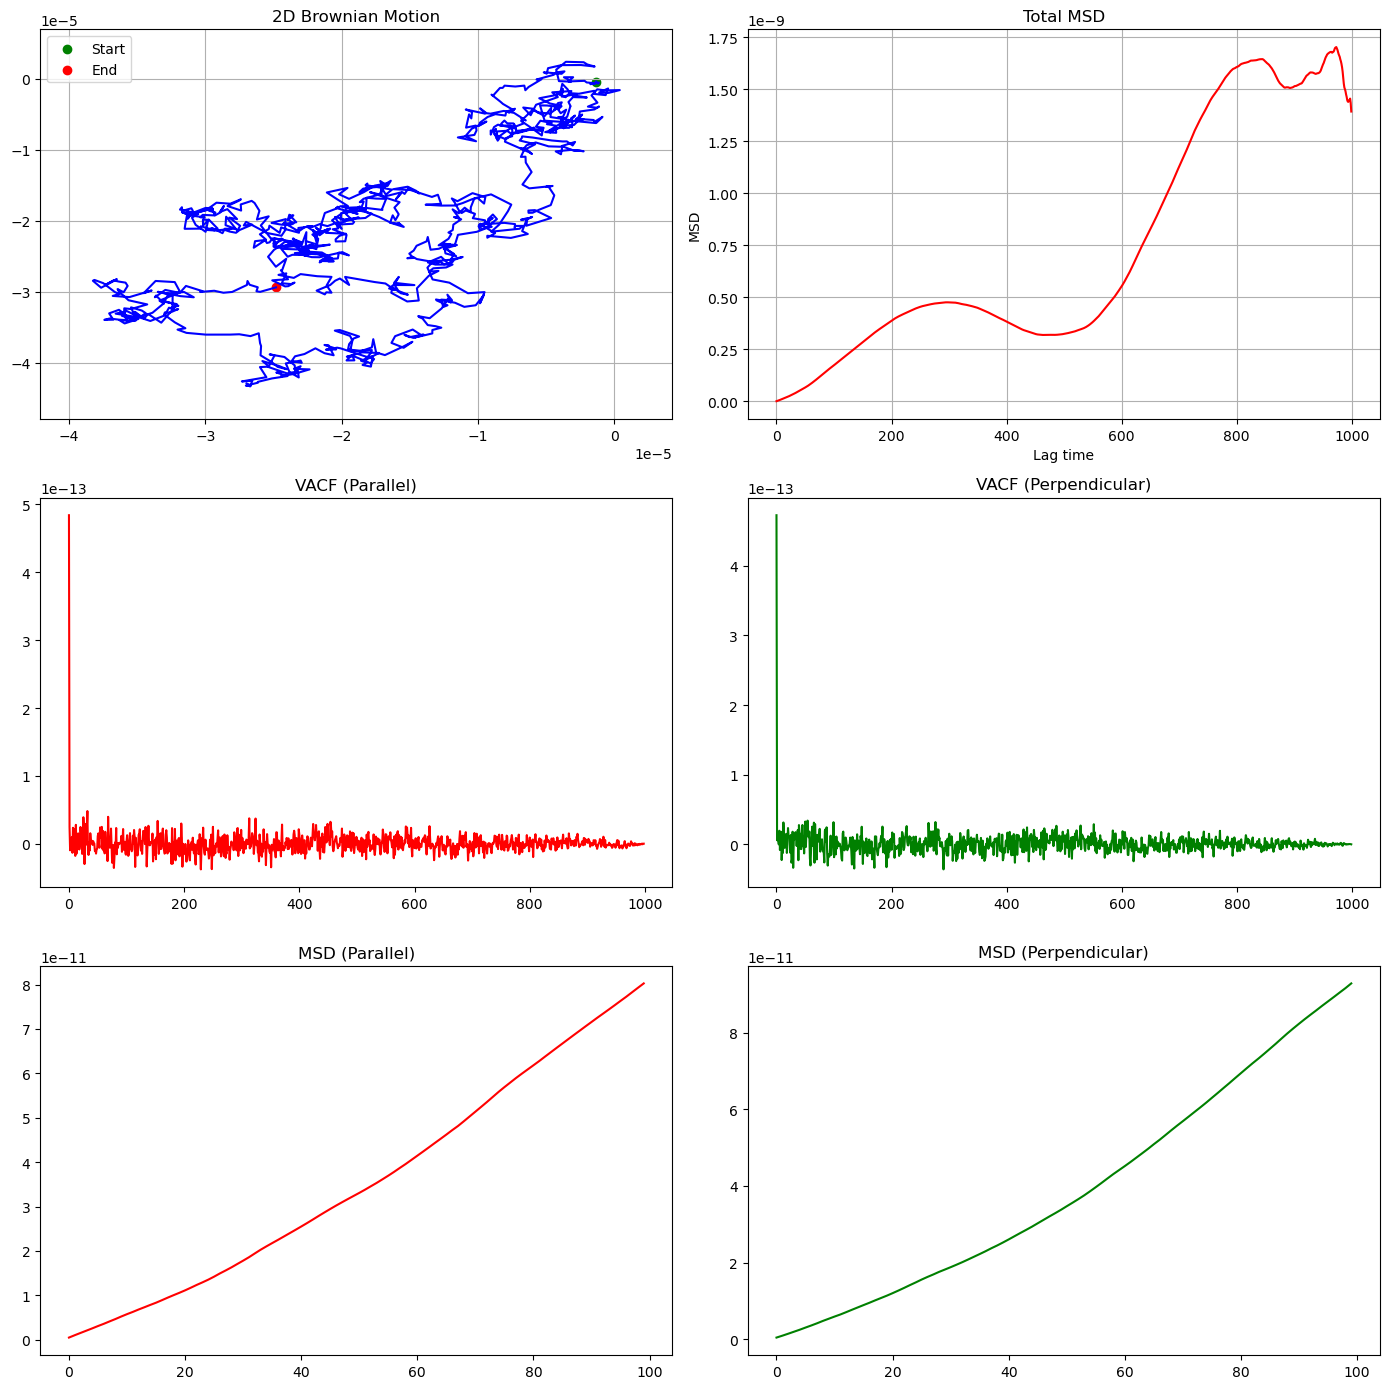

C:\Users\gongwent\AppData\Local\Temp\ipykernel_109724\1926070054.py:133: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio


def stokes_einstein(T, eta, R, k_B=1.38e-23):
    """Compute the diffusion coefficient using the Stokes-Einstein relation."""
    return k_B * T / (6 * np.pi * eta * R)

T = 300  # Kelvin (Example temperature)
eta = 1e-3  # Pa.s (Example viscosity of water)
R = 1e-6  # m (Example radius)
D_stokes = stokes_einstein(T, eta, R)


def nematic_diffusion_coefficients(anchoring='perpendicular'):
    if anchoring == 'perpendicular':
        D_parallel = 1.9e-16
        D_perpendicular = 1.4e-16
    elif anchoring == 'tangential':
        D_parallel = 2.2e-16
        D_perpendicular = 1.3e-16
    else:
        raise ValueError("Invalid anchoring type. Choose either 'perpendicular' or 'tangential'")
    return D_parallel, D_perpendicular

D_parallel, D_perpendicular = nematic_diffusion_coefficients('perpendicular')


def brownian_motion_2D(N, delta_t=1, D=1):
    """Simulate a 2D Brownian motion trajectory."""
    delta_x = np.sqrt(2 * D * delta_t) * np.random.randn(N)
    delta_y = np.sqrt(2 * D * delta_t) * np.random.randn(N)
    x = np.cumsum(delta_x)
    y = np.cumsum(delta_y)
    return x, y
def compute_msd_2D(x, y):
    """Compute 2D Mean Square Displacement for given trajectories."""
    N = len(x)
    msd = np.zeros(N)
    
    for tau in range(N):
        diffs_x = (x[:-tau or None] - x[tau:]) ** 2
        diffs_y = (y[:-tau or None] - y[tau:]) ** 2
        avg_diff = np.mean(diffs_x + diffs_y)
        msd[tau] = avg_diff
        
    return msd

def compute_velocity(position, delta_t=1):
    return np.diff(position) / delta_t

def compute_vacf(velocity):
    result = np.correlate(velocity, velocity, mode='full')
    return result[result.size // 2:] / len(velocity)

def compute_msd(position, max_lag=100):
    msd = np.array([np.mean((position[lag:] - position[:-lag]) ** 2) for lag in range(1, max_lag + 1)])
    return msd


N = 1000
x, y = brownian_motion_2D(N, D=D_stokes)
msd = compute_msd_2D(x, y)
v_x = compute_velocity(x)
v_y = compute_velocity(y)
vacf_x = compute_vacf(v_x)
vacf_y = compute_vacf(v_y)
msd_x = compute_msd(x)
msd_y = compute_msd(y)
# Visualization
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
padding = 0.1
x_range = x_max - x_min
y_range = y_max - y_min

def set_axis_limits(ax):
    ax.set_xlim(x_min - padding * x_range, x_max + padding * x_range)
    ax.set_ylim(y_min - padding * y_range, y_max + padding * y_range)

fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes[0, 0].plot(x, y, '-b')
axes[0, 0].scatter(x[0], y[0], color='green', label='Start')
axes[0, 0].scatter(x[-1], y[-1], color='red', label='End')
axes[0, 0].set_title('2D Brownian Motion')
set_axis_limits(axes[0, 0])
axes[0, 0].legend()
axes[0, 0].grid(True)

# MSD plots
axes[0, 1].plot(msd, '-r')
axes[0, 1].set_title('Total MSD')
axes[0, 1].set_xlabel('Lag time')
axes[0, 1].set_ylabel('MSD')
axes[0, 1].grid(True)

axes[1, 0].plot(vacf_x, '-r')
axes[1, 0].set_title('VACF (Parallel)')
axes[1, 1].plot(vacf_y, '-g')
axes[1, 1].set_title('VACF (Perpendicular)')
# MSD_x MSD_y plots
axes[2, 0].plot(msd_x, '-r')
axes[2, 0].set_title('MSD (Parallel)')
axes[2, 1].plot(msd_y, '-g')
axes[2, 1].set_title('MSD (Perpendicular)')

plt.tight_layout()
plt.savefig("brownian_motion_plots.png")
plt.show()

# Create GIF
filenames = []
for i in range(1, N+1):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(x[:i], y[:i], '-b')
    ax.scatter(x[0], y[0], color='green', label='Start')
    ax.scatter(x[i-1], y[i-1], color='red', s=50, label='Current Position')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('2D Brownian Motion')
    set_axis_limits(ax)
    ax.legend()
    ax.grid(True)
    filename = f'frame_{i}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

with imageio.get_writer('brownian_motion.gif', mode='I', duration=0.02) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in filenames:
    os.remove(filename)
